# K-means vector 3 dimensiones

## Proteinas, Calorias y Grasas

In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
ruta_csv = "../datasets/foundation-food.csv"
df = pd.read_csv(ruta_csv, sep=',')

In [3]:
selected_cols = ['calories', 'protein', 'total_fat']

In [4]:
foods = df[selected_cols].copy()
foods = foods.sample(n=10000, random_state=42)

In [5]:
foods.head()

,calories,protein,total_fat
1055456,571.0,64.29,35.71
1050427,350.0,12.00,0.00
382750,0.0,0.00,NaN
309780,85.0,18.31,0.70
1246220,150.0,6.67,7.50


# Limpieza de datos

In [6]:
nulos_calories = foods['calories'].isnull().sum()
nulos_protein = foods['protein'].isnull().sum()
nulos_fats = foods['total_fat'].isnull().sum()

print(f"Nulos en 'calories': {nulos_calories}")
print(f"Nulos en 'protein': {nulos_protein}")
print(f"Nulos en 'total_fat': {nulos_fats}")

Nulos en 'calories': 161
Nulos en 'protein': 34
Nulos en 'total_fat': 173


In [7]:
foods = foods.dropna(subset=selected_cols)

# Verificar el número de registros eliminados
print(f"Registros eliminados: {len(df) - len(foods)}")

Registros eliminados: 1439293


In [8]:
# Función para detectar outliers (IQR)
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    return df[(df[columna] < limite_inf) | (df[columna] > limite_sup)].index

In [9]:
# Obtener índices de outliers para cada columna
outliers_protein_idx = detectar_outliers(foods, 'protein')
outliers_calories_idx = detectar_outliers(foods, 'calories')
outliers_total_fat_idx = detectar_outliers(foods, 'total_fat')
# Unión de índices de outliers
todos_outliers = outliers_protein_idx.union(outliers_calories_idx).union(outliers_total_fat_idx)
print(f"Número total de outliers (proteina, calorias, grasas totales): {len(todos_outliers)}")

# Eliminar outliers del DataFrame
foods_clean = foods.drop(index=todos_outliers)
print(f"Registros restantes tras eliminar outliers: {len(foods_clean)}")

Número total de outliers (proteina, calorias, grasas totales): 575
Registros restantes tras eliminar outliers: 9071


## Outliners

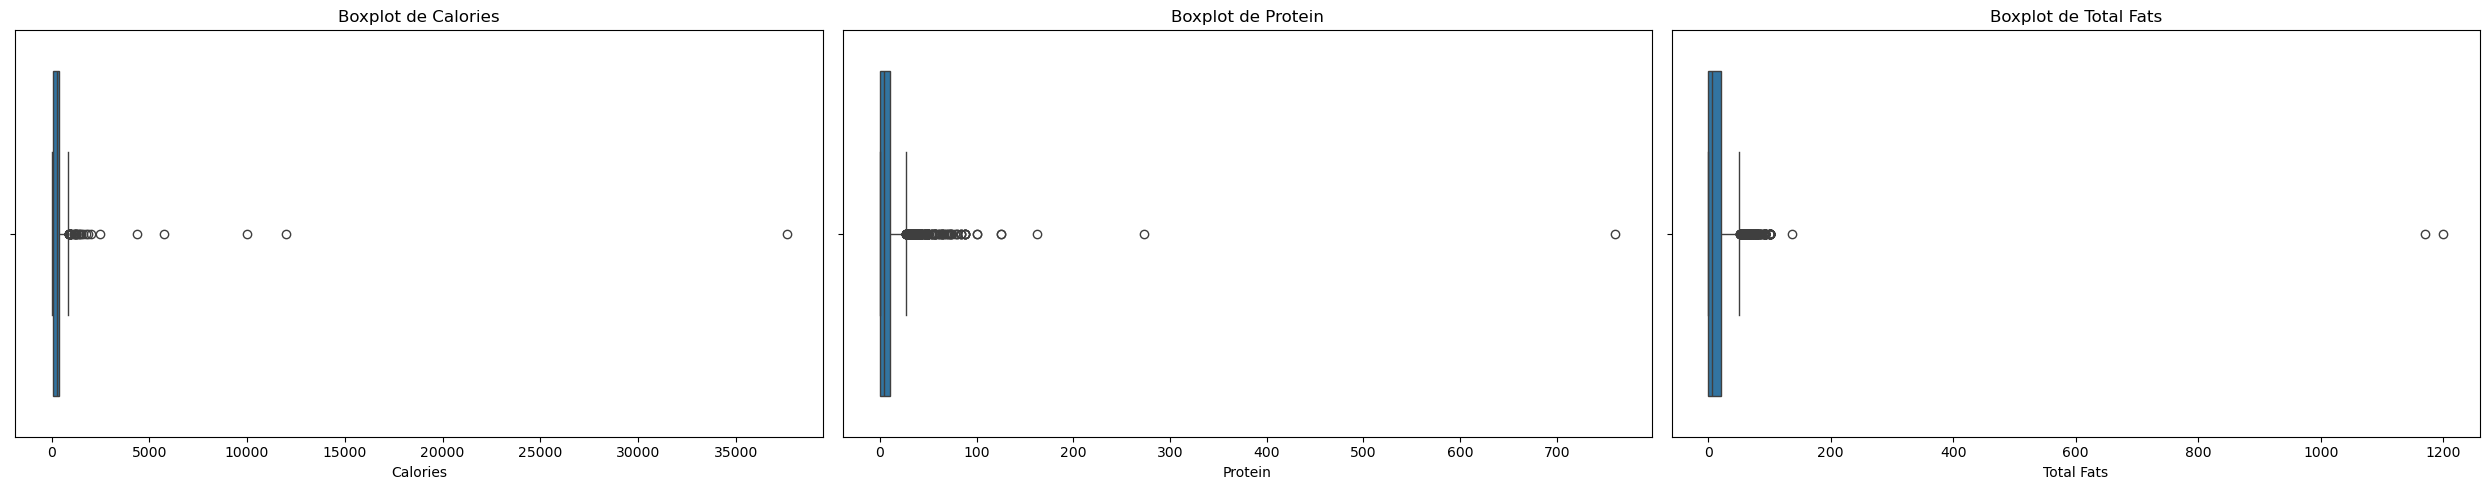

In [10]:
# Configurar el tamaño de la figura
plt.figure(figsize=(25, 5))  # Aumentamos el ancho para acomodar tres gráficos

# Boxplot para 'calories'
plt.subplot(1, 3, 1)  # 1 fila, 3 columnas, 1er gráfico
sns.boxplot(x=foods['calories'])
plt.title('Boxplot de Calories')
plt.xlabel('Calories')

# Boxplot para 'protein'
plt.subplot(1, 3, 2)  # 1 fila, 3 columnas, 2do gráfico
sns.boxplot(x=foods['protein'])
plt.title('Boxplot de Protein')
plt.xlabel('Protein')

# Boxplot para 'total_fats'
plt.subplot(1, 3, 3)  # 1 fila, 3 columnas, 3er gráfico
sns.boxplot(x=foods['total_fat'])
plt.title('Boxplot de Total Fats')
plt.xlabel('Total Fats')

# Mostrar las gráficas
plt.tight_layout()  # Ajusta automáticamente el espaciado
plt.show()


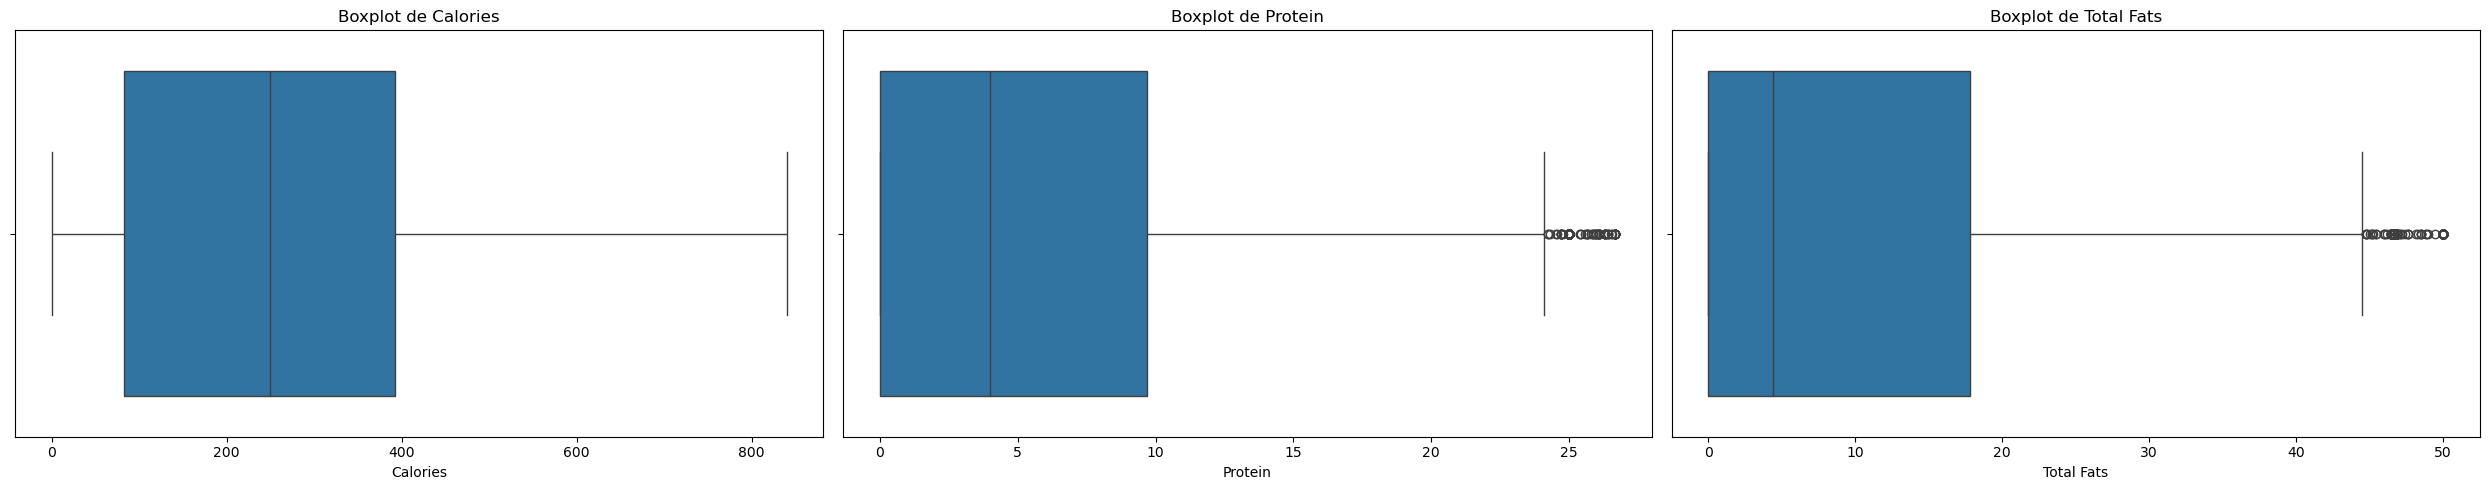

In [11]:
# Configurar el tamaño de la figura
plt.figure(figsize=(25, 5))  # Aumentamos el ancho para acomodar tres gráficos

# Boxplot para 'calories'
plt.subplot(1, 3, 1)  # 1 fila, 3 columnas, 1er gráfico
sns.boxplot(x=foods_clean['calories'])
plt.title('Boxplot de Calories')
plt.xlabel('Calories')

# Boxplot para 'protein'
plt.subplot(1, 3, 2)  # 1 fila, 3 columnas, 2do gráfico
sns.boxplot(x=foods_clean['protein'])
plt.title('Boxplot de Protein')
plt.xlabel('Protein')

# Boxplot para 'total_fats'
plt.subplot(1, 3, 3)  # 1 fila, 3 columnas, 3er gráfico
sns.boxplot(x=foods_clean['total_fat'])
plt.title('Boxplot de Total Fats')
plt.xlabel('Total Fats')

# Mostrar las gráficas
plt.tight_layout()  # Ajusta automáticamente el espaciado
plt.show()


In [12]:
# Función para contar los outliers
def contar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)  # Primer cuartil
    Q3 = df[columna].quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartílico

    # Definir los límites inferior y superior
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificar los outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

    return outliers

# Contar los outliers para 'calories' y 'protein'
outliers_calories = contar_outliers(foods_clean, 'calories')
outliers_protein = contar_outliers(foods_clean, 'protein')
outliers_fats = contar_outliers(foods_clean, 'total_fat')

# Imprimir el número de outliers
print(f"Número de outliers en 'calories': {len(outliers_calories)}")
print(f"Número de outliers en 'protein': {len(outliers_protein)}")
print(f"Número de outliers en 'total_fat': {len(outliers_fats)}")

Número de outliers en 'calories': 0
Número de outliers en 'protein': 219
Número de outliers en 'total_fat': 211


In [13]:
def plot_elbow_method(df, label, k_min=2, k_max=10):
    values = df.values
    inercias = []

    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(values)
        inercias.append(kmeans.inertia_)

    plt.figure(figsize=(6, 4), dpi=100)
    plt.plot(range(k_min, k_max), inercias, marker="o", color="red", lw=2)
    plt.xlabel("Número de Clusters")
    plt.ylabel("Inercia")
    plt.grid(True)
    plt.tight_layout()

    # Crear carpeta si no existe
    output_dir = "./out-resources/elbow_method/"
    os.makedirs(output_dir, exist_ok=True)

    filename = os.path.join(output_dir, f"{label}.png")
    plt.savefig(filename)
    print(f"Gráfico guardado como '{filename}'")

    plt.show()

# K-means model

In [14]:
escalador = MinMaxScaler().fit(foods_clean.values)
foods_scaled = pd.DataFrame(escalador.transform(foods_clean.values), columns=selected_cols)

In [15]:
foods.head()

,calories,protein,total_fat
1055456,571.0,64.29,35.71
1050427,350.0,12.00,0.00
309780,85.0,18.31,0.70
1246220,150.0,6.67,7.50
1388692,375.0,0.00,0.00


In [16]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42).fit(foods_scaled.values)
foods_scaled["cluster"] = kmeans.labels_

In [17]:
print("Inertia:", kmeans.inertia_)

Inertia: 326.8474514416444


In [18]:
sil_kmeans = silhouette_score(foods_scaled.values, kmeans.labels_)
print('Silhouette Score', sil_kmeans)

Silhouette Score 0.8097385752701527


## Exportar modelo

In [19]:
import joblib

In [20]:
# Guardar el escalador
joblib.dump(escalador, "./models/protein-calories-fats-minmax-scaler.pkl")

# Guardar el modelo KMeans
joblib.dump(kmeans, "./models/protein-calories-fats-kmeans-model.pkl")

['./models/protein-calories-fats-kmeans-model.pkl']

## Export clustering csv

In [21]:
# Preparar información para CSV
foods_info = df.loc[foods_clean.index, ['id', 'calories', 'protein', 'total_fat']].copy()
foods_info['cluster'] = kmeans.labels_

# Limpiar saltos de línea en 'name'
#foods_info['name'] = foods_info['name'].str.replace(r'[\r\n]+', ' ', regex=True).str.strip()

# Exportar CSV
#foods_info.to_csv("./out-csv/protein-calories-fats-clustering.csv", index=False)

## Data Analysis

In [22]:
# Resumen mínimos y máximos por cluster
min_max_summary = foods_info.groupby('cluster')[selected_cols].agg(['min', 'max'])
print(min_max_summary)

        calories        protein        total_fat       
             min    max     min    max       min    max
cluster                                                
0            0.0  222.0    0.00  10.00      0.00  15.79
1          143.0  840.0   11.63  26.67     14.55  50.00
2           18.0  710.0    8.24  26.67      0.00  24.56
3          224.0  800.0    0.00  14.29     10.71  50.00
4          122.0  833.0    0.00   9.52      0.00  21.43


In [23]:
# Conteo de registros por cluster
counts = foods_info['cluster'].value_counts().sort_index()
print("Conteo de registros por cluster:")
print(counts)

Conteo de registros por cluster:
cluster
0    3070
1     677
2    1503
3    1583
4    2238
Name: count, dtype: int64


## Clustering charts

Gráfico guardado como './out-resources/clustering/protein-calories-fats.png'


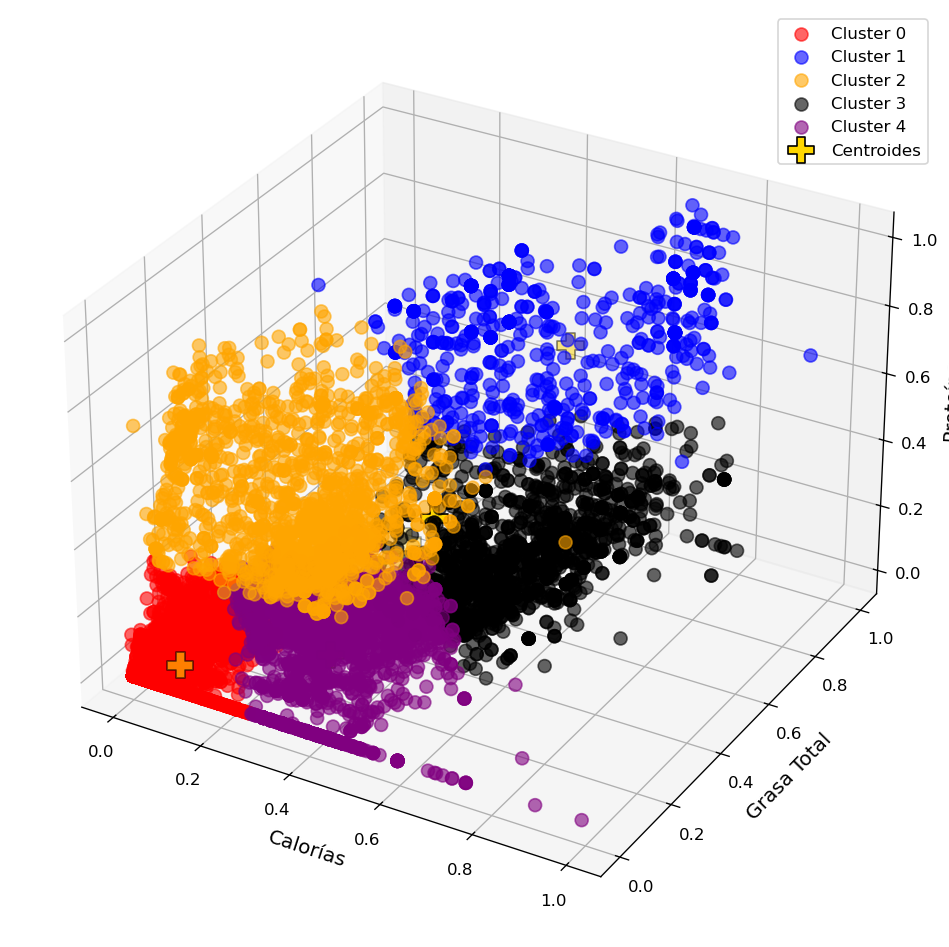

In [24]:
# Crear figura 3D
fig = plt.figure(figsize=(10, 8), dpi=120)
ax = fig.add_subplot(111, projection='3d')

# Colores para los clusters
colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]

# Graficar los puntos de cada cluster
for cluster in range(kmeans.n_clusters):
    puntos = foods_scaled[foods_scaled["cluster"] == cluster]
    ax.scatter(puntos["calories"], puntos["total_fat"], puntos["protein"],
               color=colores[cluster], label=f'Cluster {cluster}', s=60, alpha=0.6)

# Graficar los centroides
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           marker='P', s=250, color='gold', edgecolor='black', label='Centroides')

# Etiquetas y título
# ax.set_title("Clusters de Alimentos (3D)", fontsize=18)
ax.set_xlabel("Calorías", fontsize=12)
ax.set_ylabel("Grasa Total", fontsize=12)
ax.set_zlabel("Proteína", fontsize=12)
ax.legend()
plt.tight_layout()

# Guardar la imagen
filename = "./out-resources/clustering/protein-calories-fats.png"
plt.savefig(filename)
print(f"Gráfico guardado como '{filename}'")

plt.show()

# Eliminar la columna de clusters si ya no la necesitas
del foods_scaled["cluster"]

# Método del Codo

Gráfico guardado como './out-resources/elbow_method/protein-calories-fats.png'


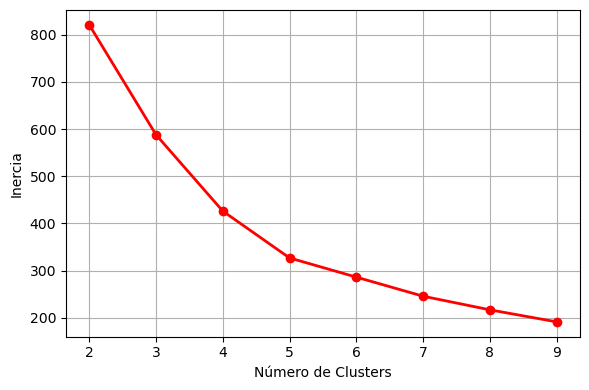

In [25]:
plot_elbow_method(foods_scaled, "protein-calories-fats")